In [1]:
import pandas as pd
import numpy as np
import os
from backtest import *
from process import *
from model import *

import lightgbm

# generate_data
# main()

## Split 1

n_groups:270,n_splits:1
group_test_starts:range(216, 270, 54)
group_train_starts:range(0, 54, 54)
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.278166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 436412
[LightGBM] [Info] Number of data points in the train set: 355445, number of used features: 1715
[LightGBM] [Info] Start training from score 0.001047


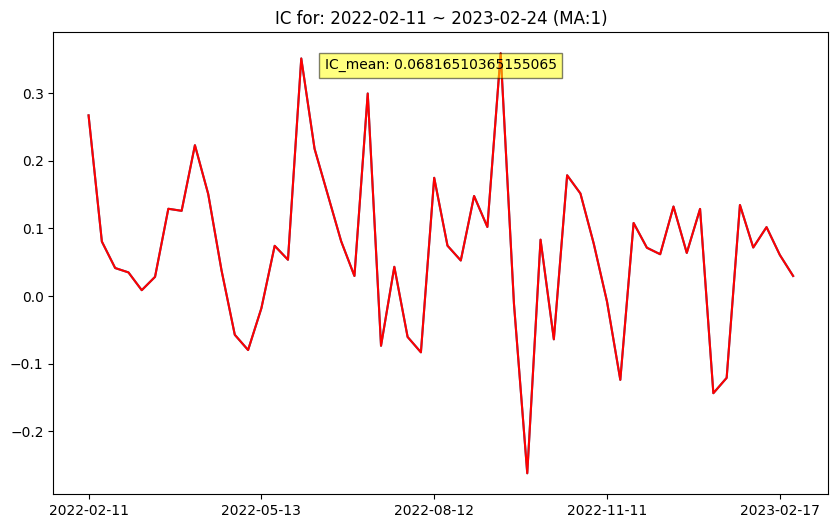

In [12]:
x = np.load('/home/qianshuofu/Yansheng_strategy/data/generate_data/data_feature.npy')
y = np.load('/home/qianshuofu/Yansheng_strategy/data/generate_data/data_label.npy',allow_pickle=True)
groups = np.load('/home/qianshuofu/Yansheng_strategy/data/generate_data/data_index.npy',allow_pickle=True)
group = groups[:,1]

train_index, test_index = next(PurgedGroupTimeSeriesSplit(n_splits=2,group_gap=1).split_2(x,y,group,splits_minus=1))
x_train, x_test, y_train, y_test, group_train, group_test = x[train_index], x[test_index], y[train_index], y[test_index], group[train_index], group[test_index]

model = lightgbm.train(params={},train_set=lightgbm.Dataset(x_train,y_train))
y_pred = model.predict(x_test)

plot_ic(y_test,y_pred,group_test,continuous=True)

       Market_Value   Gross_Profit   fee_rate     return
count  5.300000e+01      53.000000  53.000000  53.000000
mean   4.380075e+06    7370.423263   0.003683   0.001650
std    1.447084e+05  120271.511497   0.000455   0.027258
min    4.133050e+06 -286525.413390   0.002507  -0.066727
25%    4.289950e+06  -61547.306019   0.003442  -0.014235
50%    4.343450e+06   -3766.900363   0.003809  -0.000902
75%    4.490500e+06   71667.756038   0.003998   0.016135
max    4.684580e+06  401393.632438   0.004308   0.086893


,單利,複利
年化收益,0.085820,0.069218
累计收益,0.087470,0.070595
最大回撤,0.145187,0.149039
夏普(r=4%),0.235335,0.150068
波动率,0.194700,0.194700
總交易周,53.000000,53.000000
凈獲利交易周,26.000000,26.000000
凈虧損交易周,27.000000,27.000000
勝率,0.490566,0.490566
周均凈收益,0.001650,0.001332


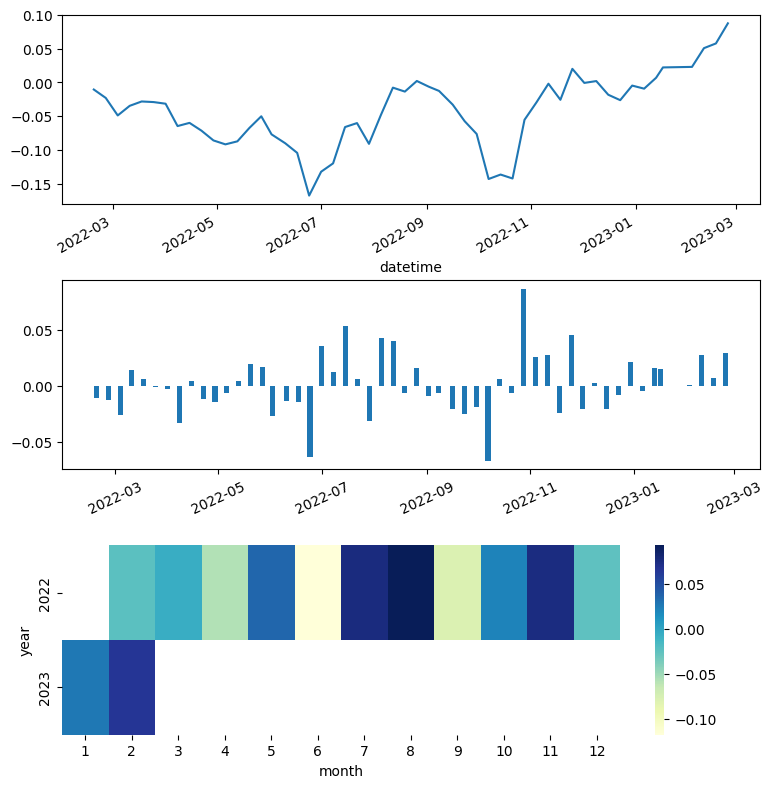

In [13]:
data = pd.read_pickle('/home/qianshuofu/Yansheng_strategy/data/initial_data/t_plus_max5_first_tradeday_adj_price.pkl')
industry = pd.read_csv('/home/qianshuofu/Yansheng_strategy/data/initial_data/industry_twse_tpex.csv')
adj_price = pd.read_feather('/home/qianshuofu/Yansheng_strategy/data/initial_data/adj_daily_TWSE_TPEX.ftr')
industry = process_industry(industry)
asset_pool = process_asset_pool(adj_price)

prediction = pd.DataFrame({'asset':groups[test_index,0],'datetime': pd.to_datetime(groups[test_index,1]),'pred':y_pred})
prediction['pred'] = prediction.groupby(['asset'])['pred'].shift(1)
prediction = prediction.dropna(subset=['pred']).set_index(['datetime','asset'])['pred']

capital, max_w = 500*10000, 0.04
holdings = get_holdings(prediction=prediction, data=data, industry=industry,
                        asset_pool=asset_pool, capital=capital, max_w=max_w)
analyze_risk_position_weekly(holdings, show_details=True)

## Split 5

n_groups:270,n_splits:5
group_test_starts:range(120, 270, 30)
group_train_starts:range(0, 150, 30)
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.029375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 434833
[LightGBM] [Info] Number of data points in the train set: 192991, number of used features: 1707
[LightGBM] [Info] Start training from score 0.001067
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.698795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 435341
[LightGBM] [Info] Number of data points in the train set: 195624, number of used features: 1710
[LightGBM] [Info] Start training from score 0.001053
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.799761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 436606


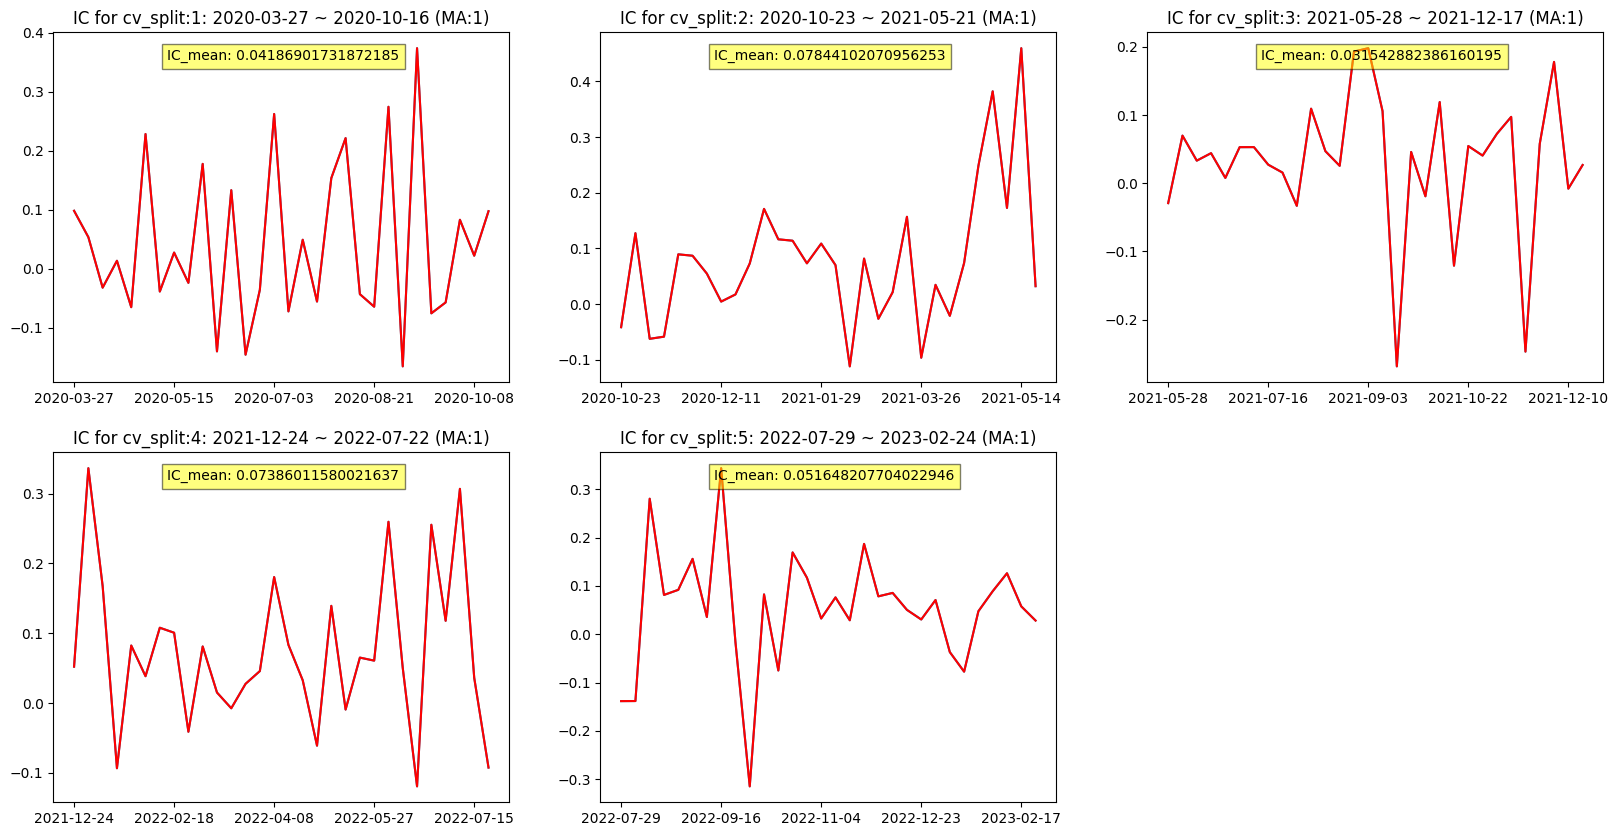

In [14]:
x = np.load('/home/qianshuofu/Yansheng_strategy/data/generate_data/data_feature.npy')
y = np.load('/home/qianshuofu/Yansheng_strategy/data/generate_data/data_label.npy',allow_pickle=True)
groups = np.load('/home/qianshuofu/Yansheng_strategy/data/generate_data/data_index.npy',allow_pickle=True)
group = groups[:,1]

test_index_list = []
y_test_list = []
y_pred_list = []
group_list = []
cv = PurgedGroupTimeSeriesSplit(n_splits=5,group_gap=1).split_2(x,y,group)
for i, (tr,te) in enumerate(cv):
    x_train, x_test, y_train, y_test, group_train, group_test = x[tr], x[te], y[tr], y[te], group[tr], group[te]
    model = lightgbm.train(params={},train_set=lightgbm.Dataset(x_train,y_train))
    y_pred = model.predict(x_test)

    test_index_list.append(te)
    y_test_list.append(y_test)
    y_pred_list.append(y_pred)
    group_list.append(group_test)

plot_ic(y_test_list,y_pred_list,group_list)

       Market_Value   Gross_Profit    fee_rate      return
count  1.490000e+02     149.000000  149.000000  149.000000
mean   4.363052e+06   20438.295633    0.003771    0.004957
std    1.764955e+05  150058.096218    0.000356    0.034991
min    3.940400e+06 -442336.391668    0.002697   -0.101757
25%    4.262410e+06  -69103.411020    0.003614   -0.015614
50%    4.363930e+06   18615.648371    0.003835    0.004458
75%    4.491000e+06   90180.092836    0.004017    0.019570
max    4.703920e+06  659076.572798    0.004454    0.153654


,單利,複利
年化收益,0.257773,0.253696
累计收益,0.738620,0.911430
最大回撤,0.205105,0.332103
夏普(r=4%),0.865974,0.849759
波动率,0.251478,0.251478
總交易周,149.000000,149.000000
凈獲利交易周,82.000000,82.000000
凈虧損交易周,67.000000,67.000000
勝率,0.550336,0.550336
周均凈收益,0.004957,0.006117


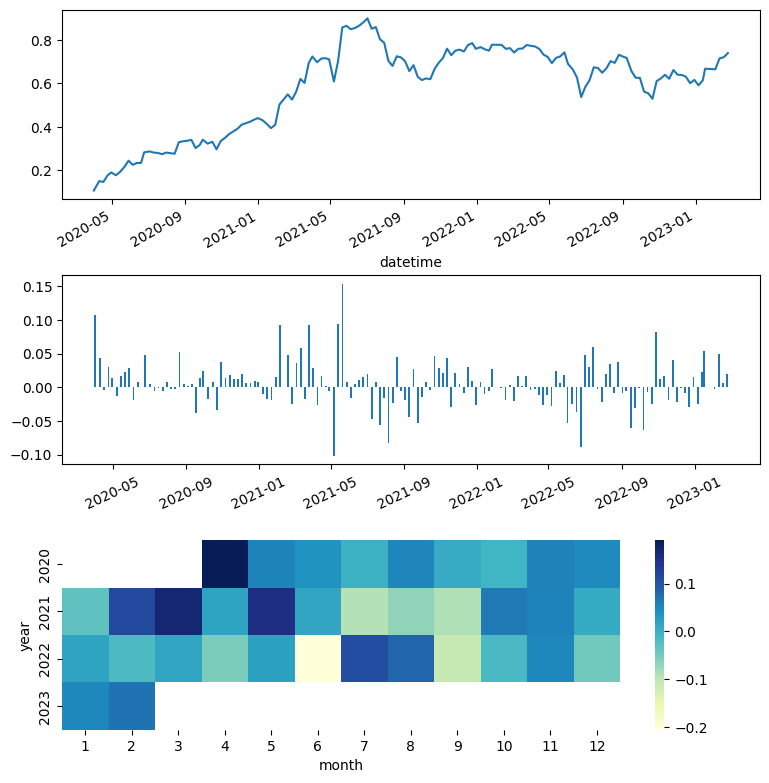

In [15]:
test_index = np.concatenate(test_index_list)

prediction = pd.DataFrame({'asset':groups[test_index,0],'datetime': pd.to_datetime(groups[test_index,1]),'pred':np.concatenate(y_pred_list)})
prediction['pred'] = prediction.groupby(['asset'])['pred'].shift(1)
prediction = prediction.dropna(subset=['pred']).set_index(['datetime','asset'])['pred']

capital, max_w = 500*10000, 0.04
holdings = get_holdings(prediction=prediction, data=data, industry=industry,
                        asset_pool=asset_pool, capital=capital, max_w=max_w)
analyze_risk_position_weekly(holdings, show_details=True)

[Text(0.5, 0, 'y_pred'),
 Text(0, 0.5, 'y_true'),
 Text(0.5, 1.0, 'The mean y_true with y_pred group')]

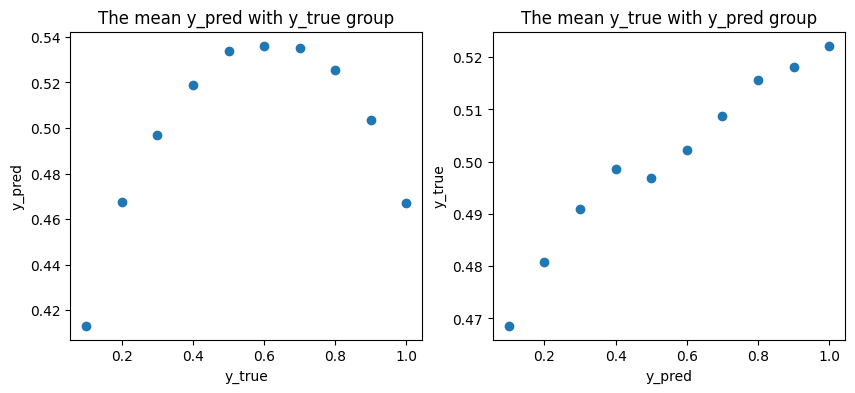

In [16]:
df = pd.DataFrame({'datetime':pd.to_datetime(groups[test_index,1]),"true":np.concatenate(y_test_list),'pred':np.concatenate(y_pred_list)})
df = df.groupby(['datetime']).rank(pct=True)
pred_list = []
true_list = []
for i in range(1,11):
    list = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    pred_list.append(df[df.true<=list[i]][df.true>list[i-1]].pred.mean())
    true_list.append(df[df.pred<=list[i]][df.pred>list[i-1]].true.mean())

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
ax1.scatter(list[1:],pred_list)
# ax1.plot(list[1:],list[1:])
ax1.set(xlabel='y_true',ylabel='y_pred',title='The mean y_pred with y_true group')
ax2.scatter(list[1:],true_list)
# ax2.plot(list[1:],list[1:])
ax2.set(xlabel='y_pred',ylabel='y_true',title='The mean y_true with y_pred group')

#plt.scatter(df.true,df.pred,alpha=0.005)

In [84]:
# prediction.loc[:'2021-07-02']
# capital, max_w = 500*10000, 0.04
# holdings = get_holdings(prediction=prediction.loc[:'2021-07-02'], data=data, industry=industry,
#                         asset_pool=asset_pool, capital=capital, max_w=max_w)
# analyze_risk_position_weekly(holdings, show_details=True)

datetime    asset
2020-04-01  1101     0.026891
            1102     0.025152
            1103     0.074453
            1104     0.097756
            1108     0.002019
                       ...   
2021-07-02  9951     0.063844
            9955    -0.022966
            9958    -0.285561
            9960     0.093145
            9962    -0.033422
Name: pred, Length: 109442, dtype: float64